In [1]:
import pandas as pd
from pathlib import Path
from macrostate.config.settings import PreprocessConfig
from macrostate.data.io import load_raw_data, clean_dataframe
from macrostate.pipelines.preprocess import build_preprocessing_pipeline

# Configuration de base
cfg = PreprocessConfig()
root = Path("/Users/etienne/Documents/Git/macro-dynamics")

# 1. Charger et nettoyer les données brutes
df_raw = load_raw_data(root / cfg.raw_data_path, cfg)
df_clean = clean_dataframe(df_raw, cfg)

print(f"Données nettoyées: {df_clean.shape}")
print(f"Période: {df_clean.index.min()} → {df_clean.index.max()}")

15:47:51 | INFO     | macrostate.data.io - Loading raw data from /Users/etienne/Documents/Git/macro-dynamics/data/raw/raw_dataset.xlsx
15:47:51 | INFO     | macrostate.data.io - Loaded 383 rows, date range: 1994-01-31 00:00:00 to 2025-11-28 00:00:00
15:47:51 | INFO     | macrostate.data.io - Forward-filled 4 values in S&P500


Données nettoyées: (383, 11)
Période: 1994-01-31 00:00:00 → 2025-11-28 00:00:00


In [2]:
# 2. Créer le dataset baseline_z (z-scores seulement)
pipeline_baseline = build_preprocessing_pipeline("baseline_z", cfg)
df_baseline = pipeline_baseline.fit_transform(df_clean)

print(f"\n📊 baseline_z: {df_baseline.shape}")
print(f"Features: {df_baseline.columns.tolist()}")

# 3. Créer le dataset z_plus_momentum (complet)
pipeline_momentum = build_preprocessing_pipeline("z_plus_momentum", cfg)
df_momentum = pipeline_momentum.fit_transform(df_clean)

print(f"\n📊 z_plus_momentum: {df_momentum.shape}")
print(f"Features: {df_momentum.columns.tolist()}")

# 4. Créer le dataset changes_only (momentum seulement)
pipeline_changes = build_preprocessing_pipeline("changes_only", cfg)
df_changes = pipeline_changes.fit_transform(df_clean)

print(f"\n📊 changes_only: {df_changes.shape}")

# 5. Créer le dataset levels_only
pipeline_levels = build_preprocessing_pipeline("levels_only", cfg)
df_levels = pipeline_levels.fit_transform(df_clean)

print(f"\n📊 levels_only: {df_levels.shape}")


📊 baseline_z: (359, 23)
Features: ['US10Y', 'US2Y', 'HY_OAS', 'IG_OAS', 'INFLATION_EXP', 'PMI_GAP', 'Unemployment', 'VIX', 'SPX_RET_1M', 'CREDIT_SPREAD', 'Confidence', 'YC_SLOPE', 'US10Y_Z', 'US2Y_Z', 'HY_OAS_Z', 'IG_OAS_Z', 'INFLATION_EXP_Z', 'PMI_GAP_Z', 'Unemployment_Z', 'VIX_Z', 'CREDIT_SPREAD_Z', 'Confidence_Z', 'YC_SLOPE_Z']

📊 z_plus_momentum: (359, 39)
Features: ['US10Y', 'US2Y', 'HY_OAS', 'IG_OAS', 'INFLATION_EXP', 'PMI_GAP', 'Unemployment', 'VIX', 'SPX_RET_1M', 'CREDIT_SPREAD', 'Confidence', 'YC_SLOPE', 'SPX_CUM', 'SPX_DD_12M', 'US10Y_D1M', 'US10Y_D6M', 'HY_OAS_D1M', 'HY_OAS_D6M', 'INFLATION_EXP_D1M', 'INFLATION_EXP_D6M', 'PMI_GAP_D1M', 'PMI_GAP_D6M', 'Unemployment_D1M', 'Unemployment_D6M', 'VIX_D1M', 'VIX_D6M', 'Confidence_D1M', 'Confidence_D6M', 'US10Y_Z', 'US2Y_Z', 'HY_OAS_Z', 'IG_OAS_Z', 'INFLATION_EXP_Z', 'PMI_GAP_Z', 'Unemployment_Z', 'VIX_Z', 'CREDIT_SPREAD_Z', 'Confidence_Z', 'YC_SLOPE_Z']

📊 changes_only: (377, 28)

📊 levels_only: (359, 23)


## Créer dataset personnalisé

In [6]:
# Configuration personnalisée: fenêtre z-score plus courte
cfg_custom = PreprocessConfig(
    zscore_window=36,  # 3 ans au lieu de 5
    zscore_min_periods=12,  # 1 an minimum
    ffill_max_gap=1,  # Remplissage plus strict
)

df_raw_custom = load_raw_data(root / cfg_custom.raw_data_path, cfg_custom)
df_clean_custom = clean_dataframe(df_raw_custom, cfg_custom)

pipeline_custom = build_preprocessing_pipeline("baseline_z", cfg_custom)
df_custom = pipeline_custom.fit_transform(df_clean_custom)

print(f"\n📊 Dataset custom (window=36): {df_custom.shape}")

15:48:44 | INFO     | macrostate.data.io - Loading raw data from /Users/etienne/Documents/Git/macro-dynamics/data/raw/raw_dataset.xlsx
15:48:44 | INFO     | macrostate.data.io - Loaded 383 rows, date range: 1994-01-31 00:00:00 to 2025-11-28 00:00:00
15:48:44 | INFO     | macrostate.data.io - Forward-filled 2 values in S&P500



📊 Dataset custom (window=36): (369, 23)


## Split data :

In [7]:
# Split temporel pour ML (pas de random split!)
def split_by_date(df, train_end, val_end):
    """Split temporel strict."""
    train = df[df.index <= train_end]
    val = df[(df.index > train_end) & (df.index <= val_end)]
    test = df[df.index > val_end]
    return train, val, test

# Exemple: train jusqu'à 2020, val 2020-2023, test après 2023
train, val, test = split_by_date(
    df_momentum,
    train_end="2020-12-31",
    val_end="2023-12-31"
)

print(f"\n📊 Train: {train.shape} ({train.index.min()} → {train.index.max()})")
print(f"📊 Val:   {val.shape} ({val.index.min()} → {val.index.max()})")
print(f"📊 Test:  {test.shape} ({test.index.min()} → {test.index.max()})")


📊 Train: (300, 39) (1996-01-31 00:00:00 → 2020-12-31 00:00:00)
📊 Val:   (36, 39) (2021-01-29 00:00:00 → 2023-12-29 00:00:00)
📊 Test:  (23, 39) (2024-01-31 00:00:00 → 2025-11-28 00:00:00)


In [8]:
# Charger les parquets déjà créés par le CLI
df_baseline = pd.read_parquet(root / "data/features/baseline_z.parquet")
df_momentum = pd.read_parquet(root / "data/features/z_plus_momentum.parquet")
df_changes = pd.read_parquet(root / "data/features/changes_only.parquet")
df_levels = pd.read_parquet(root / "data/features/levels_only.parquet")

print(f"baseline_z: {df_baseline.shape}")
print(f"z_plus_momentum: {df_momentum.shape}")
print(f"changes_only: {df_changes.shape}")
print(f"levels_only: {df_levels.shape}")

baseline_z: (359, 23)
z_plus_momentum: (359, 39)
changes_only: (377, 28)
levels_only: (359, 23)


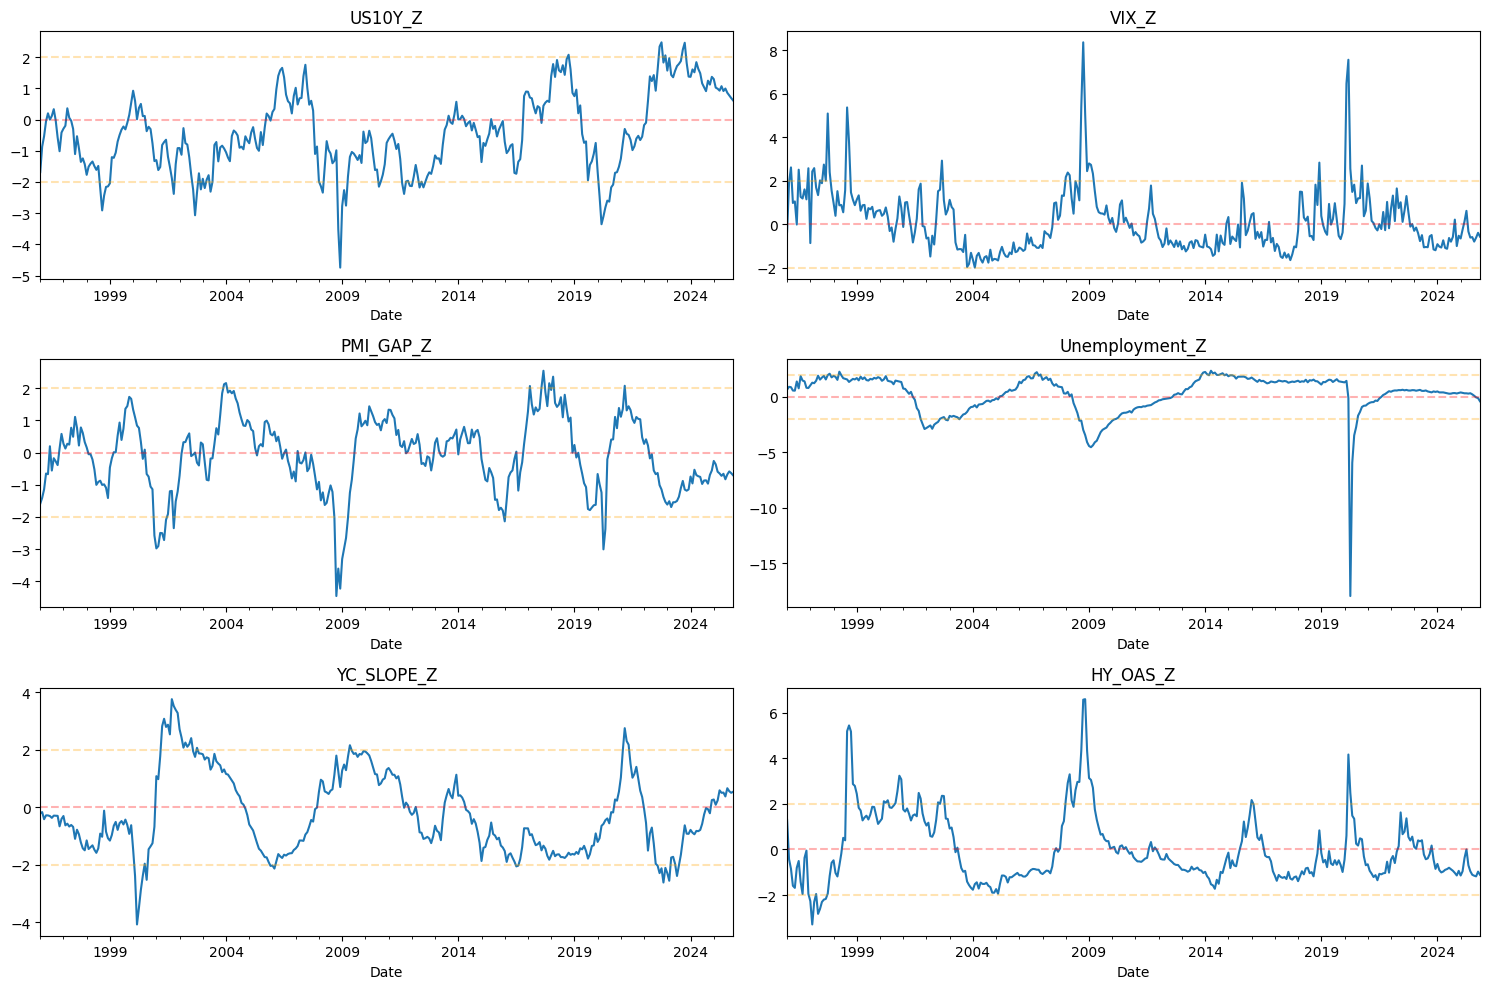

In [12]:
import matplotlib.pyplot as plt

# Visualiser quelques features z-scorées
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

features_to_plot = ['US10Y_Z', 'VIX_Z', 'PMI_GAP_Z', 
                    'Unemployment_Z', 'YC_SLOPE_Z', 'HY_OAS_Z']

for ax, feat in zip(axes.flat, features_to_plot):
    df_baseline[feat].plot(ax=ax, title=feat)
    ax.axhline(0, color='red', linestyle='--', alpha=0.3)
    ax.axhline(2, color='orange', linestyle='--', alpha=0.3)
    ax.axhline(-2, color='orange', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Sélectionner uniquement les features z-scorées pour GMM/HMM
z_features = [col for col in df_momentum.columns if col.endswith('_Z')]
df_for_gmm = df_momentum[z_features].copy()

print(f"\n📊 Dataset pour GMM: {df_for_gmm.shape}")
print(f"Features: {df_for_gmm.columns.tolist()}")

# Vérifier qu'il n'y a pas de NaN
print(f"NaN count: {df_for_gmm.isna().sum().sum()}")


📊 Dataset pour GMM: (359, 11)
Features: ['US10Y_Z', 'US2Y_Z', 'HY_OAS_Z', 'IG_OAS_Z', 'INFLATION_EXP_Z', 'PMI_GAP_Z', 'Unemployment_Z', 'VIX_Z', 'CREDIT_SPREAD_Z', 'Confidence_Z', 'YC_SLOPE_Z']
NaN count: 0
